epoch:10, loss:0.090
epoch:20, loss:0.059
epoch:30, loss:0.042
epoch:40, loss:0.032
epoch:50, loss:0.026
epoch:60, loss:0.021
epoch:70, loss:0.018
epoch:80, loss:0.015
epoch:90, loss:0.014
epoch:100, loss:0.013
epoch:110, loss:0.012
epoch:120, loss:0.011
epoch:130, loss:0.010
epoch:140, loss:0.010
epoch:150, loss:0.010
epoch:160, loss:0.010
epoch:170, loss:0.009
epoch:180, loss:0.010
epoch:190, loss:0.009
epoch:200, loss:0.009
epoch:210, loss:0.009
epoch:220, loss:0.009
epoch:230, loss:0.009
epoch:240, loss:0.009
epoch:250, loss:0.008
epoch:260, loss:0.008
epoch:270, loss:0.009
epoch:280, loss:0.008
epoch:290, loss:0.008
epoch:300, loss:0.008
损失:0.008, 533.9 tokens/秒 在 cuda:0上


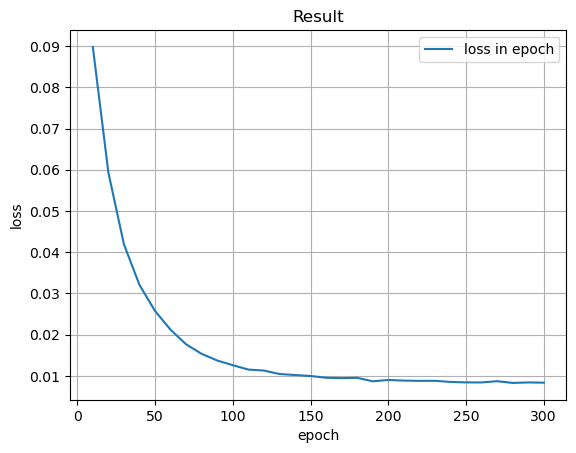

In [4]:
import torch, utils, math, collections, nmt_utils
from torch import nn
class Seq2SeqEncoder(utils.Encoder):
    """
    用于序列到序列学习的循环神经网络编码器。
    使用了嵌入层(embedding layer)来获得输入序列中每个词元的特征向量。
    嵌入层的权重是一个矩阵,其行数等于输入词表的大小(vocab_size),其列数等于特征向量的维度(embed_size)。
    对于任意输入词元的索引i,嵌入层获取权重矩阵的第i行(从0开始)以返回其特征向量。
    选择了一个多层门控循环单元来实现编码器。
    """
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size) # 嵌入层
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)

    def forward(self, X, *args):
        X = self.embedding(X) # 输出shape:(batch_size, num_steps, embed_size)
        X = X.permute(1,0,2) # 转置后输出shape:(num_steps, batch_size, embed_size) 第一个轴对应时间步
        output, state = self.rnn(X)
        # 输出output的形状为 (num_steps, batch_size, num_hiddens)
        # 输出state的形状为  (num_layers, batch_size, num_hiddens)
        return output, state # 输出和隐状态 最后一次更新的隐状态即为要传递给Decoder的上下文变量
    
# encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
# encoder.eval()
# X = torch.zeros((4, 7), dtype=torch.long)
# output, state = encoder(X)
# output.shape

class Seq2SeqDecoder(utils.Decoder):
    """
    用于序列到序列学习的循环神经网络编码器。
    实现解码器时，我们直接使用编码器最后一个时间步的隐状态来初始化解码器的隐状态。
    这要求使用循环神经网络实现的编码器和解码器具有相同数量的层和隐藏单元。
    为了进一步包含经过编码的输入序列的信息,上下文变量在所有的时间步与解码器的输入进行拼接。
    为了预测输出词元的概率分布，在循环神经网络解码器的最后一层使用全连接层来变换隐状态。
    """
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, encoder_outputs, *args):
        #return encoder_outputs[1] 
        # 使用编码器最后一个时间步的隐状态来初始化解码器的隐状态 1表示的是输出(output, state)中的state
        return (encoder_outputs[1], encoder_outputs[1][-1])
    
    def forward(self, X, state):
        X = self.embedding(X).permute(1, 0, 2) # X.shape:(num_steps, batch_size, embed_size)
        context = state[-1].repeat(X.shape[0], 1, 1) # 广播context，使其具有与X相同的num_steps
        encode, state = state[1], state[0]
        X_and_context = torch.concat((X, context), dim=2) # 在embed_size维度上连接输入X和上下文变量state
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output: (batch_size, num_steps, num_hiddens)
        # state:  (num_layers, batch_size, num_hiddens)
        # return output, state
        return output, (state, encode)

# decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
# decoder.eval()
# state = decoder.init_state(encoder(X))
# output, state = decoder(X, state)
# output.shape, state.shape

class MaskedSoftmaxCrossEntropyLoss(nn.CrossEntropyLoss):
    """带屏蔽不相关项的交叉熵损失函数"""
    def sequence_mask(self, X, valid_len, value=0):
        """
        在序列中将不相关的项(如用于填充的"<pad>")替换为value值的函数\n
        参数:\n
            X : 未经转置的原始数据 shape=(batch_size, num_steps, num_features)\n
            valid_len : 一个列表,指示X的每个batch的有效长度\n
            value : 用于替换不相关项的值\n
        
        例如,如果两个序列的有效长度(不包括填充词元)分别为1和2,\n
        则第一个序列的第一项和第二个序列的前两项之后的剩余项将被清除为value指定的值(默认为0)。\n
        即:将填充词元的预测排除在损失函数的计算之外
        """
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None] # 应用广播机制进行比较
        # 这里, torch.arange获取了一个从0到maxlen-1的整数序列并用[None, :]升为shape=(1, maxlen)的二维矩阵。
        # valid_len通过[:, None]升为shape=(len(valid_len), 1)的二维矩阵。 
        # 这里的通过None升维的操作和unsqueeze()是一样的
        # 之后进行比较 通过广播机制, arange数组中长度<valid_len的部分得到True, 其他为False。 得到了一张布尔表mask
        # 通过布尔表, 进行X[~mask]=value即可通过切片把X对应的位置替换为value指定的值。
        X[~mask] = value
        return X

    def forward(self, pred, label, valid_len) -> torch.Tensor:
        """
        参数:\n
            pred : Tensor, shape=(batch_size, num_steps, vocab_size)\n
            label : Tensor, shape=(batch_size, num_steps)\n
            valid_len : Tensor, shape=(batch_size,)\n
        返回:\n
            weighted_loss : Tensor, shape = (batch_size,)
        """
        weights = torch.ones_like(label, device=label.device)
        weights = self.sequence_mask(weights, valid_len)  # 将weights中不相关的位置置0后与原始损失相乘即可在序列中屏蔽不相关的项
        self.reduction ='none'
        unweighted_loss = super().forward(pred.permute((0, 2, 1)), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)  # 计算加权后的平均损失
        return weighted_loss
        
def seq2seq_train(net, data_iter, lr, num_epochs, target_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                # nn.GRU的_flat_weights_names是参数名字的集合, 例:['weight_ih_l0', 'weight_hh_l0', 'bias_ih_l0', 'bias_hh_l0']
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss_function = MaskedSoftmaxCrossEntropyLoss()
    timer = utils.Timer()
    res = utils.ResVisualization(xlist=[[]], ylist=[[]], legend_names=['loss in epoch'],
                                is_grid=True, title='Result', xlabel='epoch', ylabel='loss')
    net.train()
    with timer:
        for epoch in range(num_epochs):
            metric = utils.Accumulator(2) # 训练损失总和, 词元数量
            for batch in data_iter:
                # batch.shape:(src_array, src_valid_len, tgt_array, tgt_valid_len)
                optimizer.zero_grad()
                X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
                # 给每组文本列添加起始标志'<bos>'
                bos = torch.tensor([target_vocab['<bos>']]*Y.shape[0], device=device).reshape(-1, 1)
                decoder_input = torch.cat([bos, Y[:, :-1]], dim=1)
                Y_hat, _ = net(X, decoder_input, X_valid_len)
                loss = loss_function(Y_hat, Y, Y_valid_len)
                loss.sum().backward()
                utils.grad_clipping(net, 1)
                num_tokens = Y_valid_len.sum()
                optimizer.step()
                with torch.no_grad():
                    metric.add(loss.sum(), num_tokens)
            if (epoch+1) % 10 == 0:
                res.add(epoch+1, metric[0]/metric[1], 'loss in epoch')
                print(f"epoch:{epoch+1}, loss:{metric[0]/metric[1]:.3f}")
    print(f"损失:{metric[0]/metric[1]:.3f}, {metric[1]/timer.get_elapsed_time():.1f} tokens/秒 在 {str(device)}上")
    res.plot_res()

def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, 
                    num_steps, device, save_attention_weights=False):
    """序列到序列模型的预测"""
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    encoder_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = nmt_utils.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    encoder_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0) # 添加批量轴
    encoder_outputs = net.encoder(encoder_X, encoder_valid_len)
    decoder_state = net.decoder.init_state(encoder_outputs, encoder_valid_len)
    decoder_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0) # 添加批量轴
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, decoder_state = net.decoder(decoder_X, decoder_state)
        decoder_X = Y.argmax(dim=2) # 使用具有最高可能性的词元, 作为解码器在下一时间步的输入
        pred = decoder_X.squeeze(dim=0).type(torch.int32).item()
        if save_attention_weights: # 保存注意力权重
            attention_weight_seq.append(net.decoder.attention.attention_weights)
        if pred == tgt_vocab['<eos>']: # 一旦结束词元被预测,输出序列的生成就完成了
            break
        output_seq.append(pred)
    return ''.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq


embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, utils.try_gpu()
train_iter, src_vocab, tgt_vocab =  utils.load_data_nmt(batch_size, num_steps)

encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net =  utils.EncoderDecoder(encoder, decoder)
seq2seq_train(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [5]:
def bleu(pred_seq, label_seq, k):
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred)) # 初始惩罚项,用于降低较短序列(因为容易预测)的分数 公式的前半部分
    for n in range(1, min(k, len_pred)+1):
        num_matches, label_ngram_cnt = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1): # 初始化标签序列的n元语法表
            label_ngram_cnt[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1): # 查找预测序列中有多少和标签序列表匹配的n元语法
            if label_ngram_cnt[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_ngram_cnt[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n)) # p_n * 1/2^n 公式的后半部分
    return score

engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va!, bleu 0.000
i lost . => j'aiperdu., bleu 0.000
he's calm . => ilestestmaladeestpayé., bleu 0.000
i'm home . => jesuis<unk><unk>étéça., bleu 0.000


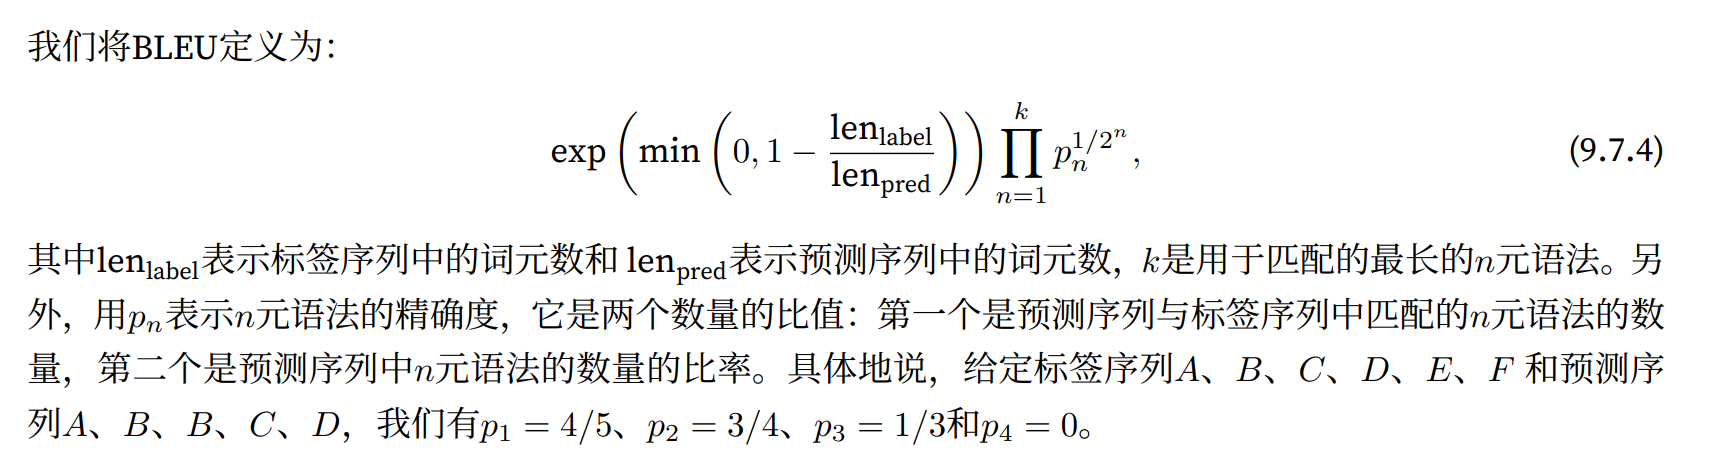